In [241]:
#  Import libraries
from __future__ import print_function, absolute_import, division, unicode_literals

from astropy.io import fits
from astropy.stats import sigma_clip
from datetime import datetime
import fileinput
import glob, os, sys
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import warnings

In [172]:
from gaussian import gaussian, function


In [242]:
def poisson(mean,k):
    pois = np.power(mean,k)/math.factorial(k)
    return pois
        

# Bias Frames

In [2]:
cd DATA

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [3]:
files_bias = [f for f in os.listdir('BIAS') if f.endswith('.fits')]


In [4]:
cd BIAS

C:\Users\Adiputra\siuling\UCSC\136\DATA\BIAS


In [5]:
bias_data = []

for i in range(len(files_bias)):
    hdu_bias = fits.open(files_bias[i])
    if not hdu_bias[0].header['EXPTIME']:
        clip_bias = sigma_clip(hdu_bias[0].data)
        bias_data.append(clip_bias)
        
bias_masks = [arr.mask for arr in bias_data] # Get masks for each image
final_bias = np.ma.masked_array(data=np.dstack(bias_data), mask=np.dstack(bias_masks)) # Create stacked masked array

In [6]:
(final_bias).shape

(510, 765, 19)

numpy.ma.core.MaskedArray

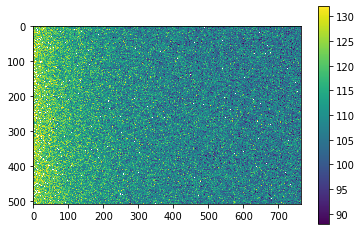

In [9]:
plt.imshow(bias_data[0])
plt.colorbar()
type(bias_data[4])

numpy.ma.core.MaskedArray

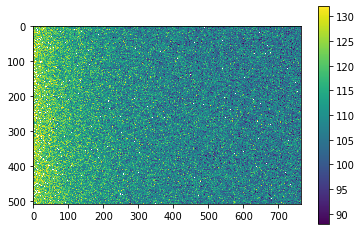

In [10]:
plt.imshow(final_bias[:,:,0])
plt.colorbar()
type(final_bias[:,:,0])

Find stats of bias

In [236]:
bias_mean = np.mean(final_bias, axis=2, keepdims=True)
bias_median = np.median(final_bias, axis=2, keepdims=True)
bias_std = np.std(final_bias, axis=2, keepdims=True)

Sigma clip bias data

#### Create Master Bias

In [222]:
master_bias = np.mean(final_bias, axis=2)
master_bias

masked_array(
  data=[[125.46666666666667, 125.70588235294117, 125.93333333333334, ...,
         107.10526315789474, 107.10526315789474, 106.10526315789474],
        [123.53333333333333, 125.58823529411765, 123.33333333333333, ...,
         103.36842105263158, 103.47368421052632, 105.0],
        [123.93333333333334, 123.85714285714286, 123.11111111111111, ...,
         103.78947368421052, 107.10526315789474, 103.63157894736842],
        ...,
        [124.53846153846153, 122.84615384615384, 126.0625, ...,
         106.42105263157895, 104.6842105263158, 105.78947368421052],
        [125.17647058823529, 125.86666666666666, 124.73333333333333, ...,
         108.84210526315789, 105.6842105263158, 109.57894736842105],
        [127.17647058823529, 126.83333333333333, 124.0, ..., 108.0,
         105.21052631578948, 109.78947368421052]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [221]:
master_bias_f = master_bias.flatten()
master_bias_f

masked_array(data=[125.46666666666667, 125.70588235294117,
                   125.93333333333334, ..., 108.0, 105.21052631578948,
                   109.78947368421052],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [192]:
print(np.min(master_bias))
print(np.max(master_bias))

100.26315789473684
132.0


In [243]:
bias_fit = poisson(bias_mean, bins)
sns.distplot(master_bias.flatten(), kde=False, bins = 300,)
plt.plot(bins, bias_fit)
plt.xlim(100, 140)
plt.show()

KeyboardInterrupt: 

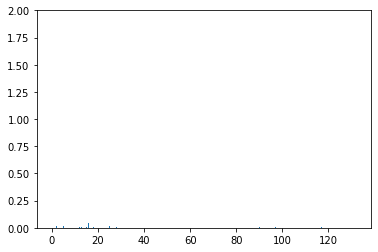

In [231]:
cnts, bins = np.histogram(master_bias_f, bins='auto')

plt.hist(cnts, bins=bins, density=True)
plt.ylim((0.,2.))
#plt.yscale('log')
#plt.xscale('log')
#plt.colorbar()
plt.show()

#set_xlabel('Counts')
#plt.savefig('/content/sampleunprocessed.png')

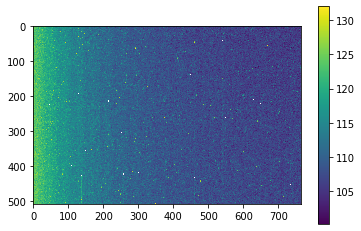

In [15]:
plt.imshow(master_bias)
plt.colorbar()

# Dark Files

In [154]:
pwd

'C:\\Users\\Adiputra\\siuling\\UCSC\\136'

In [150]:
cd ..

C:\Users\Adiputra\siuling\UCSC\136


In [107]:
files_dark = [f for f in os.listdir('DARK') if f.endswith('.fits')]


In [108]:
cd DARK

C:\Users\Adiputra\siuling\UCSC\136\DATA\DARK


In [109]:
dark_data = []
for i in range(len(files_dark)):
    hdu_dark = fits.open(files_dark[i])
    if hdu_dark[0].header['EXPTIME'] > 0:
        correct_dark = (hdu_dark[0].data - master_bias)/hdu_dark[0].header['EXPTIME']
        clip_dark = sigma_clip(correct_dark)
        dark_data.append(clip_dark)
        
dark_masks = [arr.mask for arr in dark_data] # Get masks for each image
final_dark = np.ma.masked_array(data=np.dstack(dark_data), mask=np.dstack(dark_masks)) # Create stacked masked array

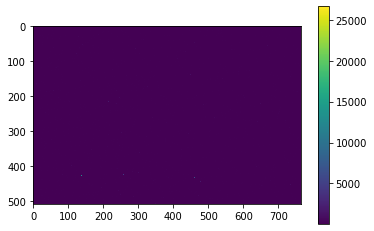

In [21]:
#raw dark
plt.imshow(hdu_dark[0].data)
plt.colorbar()

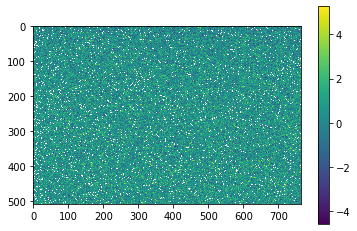

In [22]:
#corrected dark
plt.imshow(correct_dark)
plt.colorbar()

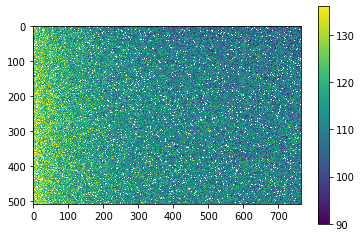

In [23]:
#clipped dark
plt.imshow(clip_dark)
plt.colorbar()

Find stats for darks

In [25]:
dark_mean = np.mean(final_dark, axis=2, keepdims=True)
dark_median = np.median(final_dark, axis=2, keepdims=True)
dark_std = np.std(final_dark, axis=2, keepdims=True)

C:\Users\Adiputra\Software\Anaconda3-2020.02\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Create master dark

In [110]:
master_dark = np.mean(final_dark, axis=2)

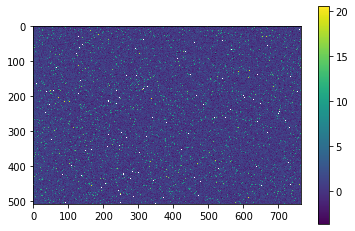

In [111]:
plt.imshow(master_dark)
plt.colorbar()

# Flat Frames

In [112]:
cd ..

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [113]:
files_flat = [f for f in os.listdir('FLAT') if f.endswith('.fits')]

In [114]:
cd FLAT

C:\Users\Adiputra\siuling\UCSC\136\DATA\FLAT


In [115]:
flatdata = []
for i in range(len(files_flat)):
    hdu_flat = fits.open(files_flat[i])
    if hdu_flat[0].header['EXPTIME'] > 0:
        if hdu_flat[0].header['APTDIA'] > 0:
            #correct the flat
            correct_flat = (((hdu_flat[0].data - master_bias)/hdu_flat[0].header['EXPTIME']) - master_dark)
            #clip flat
            clip_flat = sigma_clip(correct_flat)
            #find the minimum of the flat for normalization
            min_flat = np.min(clip_flat)
            #normalize flat
            norm_flat = clip_flat/min_flat
            #add flat to the list flatdata
            flatdata.append(norm_flat)
            
flat_masks = [arr.mask for arr in flatdata] # Get masks for each image
final_flat = np.ma.masked_array(data=np.dstack(flatdata), mask=np.dstack(flat_masks)) # Create stacked masked array
            

In [33]:
flat_mean = np.mean(flatdata, axis=2, keepdims=True)
flat_median = np.median(flatdata, axis=2, keepdims=True)
flat_std = np.std(flatdata, axis=2, keepdims=True)

### Create Master Flat

In [116]:
master_flat = np.mean(final_flat, axis=2)

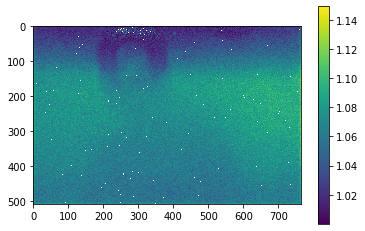

In [117]:
plt.imshow(master_flat)
plt.colorbar()

# Science Frames

In [118]:
cd ..

C:\Users\Adiputra\siuling\UCSC\136\DATA


In [119]:
files_sci = [f for f in os.listdir('TWI_SKY') if f.endswith('.fits')]

In [120]:
cd TWI_SKY

C:\Users\Adiputra\siuling\UCSC\136\DATA\TWI_SKY


In [121]:
sci_data = []
sci_mean = []
sci_median = []
sci_std = []
obs_t_sci = []

In [40]:
np.mean(master_flat)

1.0634571357626872

In [41]:
fits.open(files_sci[62])[0].header['exptime']

60.0

In [122]:
warnings.filterwarnings("ignore")

for i in range(len(files_sci)):
    hdu_sci = fits.open(files_sci[i])
    header_sci = hdu_sci[0].header
    if header_sci['EXPTIME'] > 0:
        if header_sci['APTDIA'] > 0:
            correct_sci = (((hdu_sci[0].data - master_bias) / header_sci['EXPTIME']) - master_dark) / master_flat
            clip_sci = sigma_clip(correct_sci)
            #mean_sci = np.mean(clip_sci)
            #median_sci = np.median(clip_sci)
            #std_sci = np.std(clip_sci)
            
            sci_data.append(clip_sci)
            #sci_mean.append(mean_sci)
            #sci_median.append(median_sci)
            #sci_std.append(std_sci)
            
            time = header_sci['TIME-OBS']
            obs_t_sci.append(time)   
            
sci_masks = [arr.mask for arr in sci_data] # Get masks for each image
final_sci = np.ma.masked_array(data=np.dstack(sci_data), mask=np.dstack(sci_masks)) # Create stacked masked array

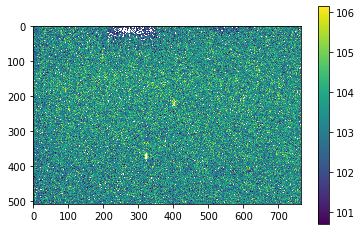

In [123]:
plt.imshow(final_sci[:,:,62]) #oh no
plt.colorbar()

### Calculate Stats

In [124]:
for i in range(final_sci.shape[2]):
    mean = np.mean(final_sci[:,:,i])
    median = np.median(final_sci[:,:,i])
    std = np.std(final_sci[:,:,i])
    
    sci_mean.append(mean)
    sci_median.append(median)
    sci_std.append(std)

### Change OBS-TIME to secs

In [126]:
seconds = []
for i in range(len(obs_t_sci)):
    dt = datetime.strptime(obs_t_sci[i], '%H:%M:%S.%f')
    total_seconds = dt.second + dt.minute*60 + dt.hour*3600
    seconds.append(total_seconds)


[10513, 10516, 10519, 10522, 10526, 10529, 10532, 10535, 10538, 10542, 10702, 10706, 10710, 10714, 10718, 10723, 10727, 10731, 10735, 10739, 10873, 10878, 10884, 10889, 10895, 10900, 10906, 10911, 10917, 10922, 11088, 11096, 11103, 11111, 11118, 11126, 11133, 11141, 11148, 11156, 11273, 11285, 11298, 11310, 11323, 11335, 11348, 11360, 11373, 11385, 11415, 11437, 11460, 11482, 11505, 11527, 11550, 11572, 11595, 11617, 11677, 11740, 11802, 11865, 11927, 12039, 12222]


# Plot counts vs. time

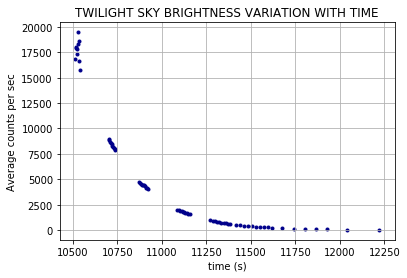

In [127]:


plt.xlabel('time (s)') 
plt.ylabel('Average counts per sec') 
plt.title('TWILIGHT SKY BRIGHTNESS VARIATION WITH TIME')
plt.scatter(seconds, sci_mean, label="projected" , color = 'darkblue', marker='.')
plt.grid()
plt.show()

### Linearize data

In [156]:
y = np.log(sci_mean)
m, b = np.polyfit(seconds, y, 1)

In [157]:
m

-0.004013770678512502

In [158]:
# Linear function:
def func(x,m,b):
    f = []
    for i in x:
        y = m*i + b
        f.append(y)
    return f

In [159]:
y_fit = func(seconds,m,b)

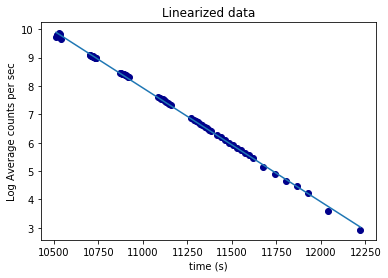

In [160]:
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts per sec') 
plt.title('Linearized data')
plt.scatter(seconds, y, label="projected" , color = 'darkblue')
plt.plot(seconds, y_fit)
#plt.savefig("Pau-Sanchez_Sky_Bri.pdf")


### Fit a line

In [166]:
B = -6/1
Ro = 6378.1*10**3
Z = 150*10**3
phi = np.radians(12)

In [167]:
dphi_dt = m*(Z)/(B*phi*Ro) #rads/sec

In [168]:
dphi_dt

7.51177596685426e-05

In [169]:
rate_deg_hs = np.degrees(dphi_dt)*3600

In [170]:
rate_deg_hs*24

371.85960344994936